In [15]:
import psycopg2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
import tensorflow as tf
import assets.helpers as hp
import assets.metrics as m
import importlib


In [2]:
RANDOM_STATE = 42
# WINDOW_LENGTH = 16
WINDOW_LENGTH = 24
MIN_LOS_ICU = 24
CLIENT_COUNT = 4
USE_FL = False
VITAL_NAMES = ['heartrate', 'sysbp', 'diasbp', 'meanbp', 'resprate', 'tempc', 'spo2']
LAB_NAMES = ['albumin', 'bun', 'bilirubin', 'lactate', 'bicarbonate', 'bands', 'chloride', 'creatinine', 'glucose', 'hemoglobin', 'hematocrit', 'platelet', 'potassium', 'ptt', 'sodium', 'wbc']
FOLDER_SUFFIX = ''

# Load data

## From SQL:

In [3]:
# Connect to db
conn = psycopg2.connect(host='localhost', port=5432, dbname='mimic', user='zainab', password='password')
cur = conn.cursor() 

# TODO
# Read vital signs
# vitals = pd.read_sql_query(f'SELECT * FROM mimiciii.vitals_windowed_{WINDOW_LENGTH:d}h(min{MIN_LOS_ICU:d}h);', conn)

# # Read in labs values
# labs = pd.read_sql_query(f'SELECT * FROM mimiciii.labs_windowed_{WINDOW_LENGTH:d}h(min{MIN_LOS_ICU:d}h);', conn)


# Read vital signs
vitals = pd.read_sql_query(f'SELECT * FROM mimiciii.vitals_windowed_{WINDOW_LENGTH:d}h;', conn)

# Read in labs values
labs = pd.read_sql_query(f'SELECT * FROM mimiciii.labs_windowed_{WINDOW_LENGTH:d}h;', conn)
# Close the cursor and connection to so the server can allocate bandwidth to other requests
cur.close()
conn.close()

/tmp/ipykernel_7456/628128596.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  vitals = pd.read_sql_query(f'SELECT * FROM mimiciii.vitals_windowed_{WINDOW_LENGTH:d}h;', conn)
/tmp/ipykernel_7456/628128596.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  labs = pd.read_sql_query(f'SELECT * FROM mimiciii.labs_windowed_{WINDOW_LENGTH:d}h;', conn)


## From File:

In [3]:
data_path = f'data/min{MIN_LOS_ICU:d}h/'

# TODO
# vitals = pd.read_pickle(data_path + f'vitals_windowed_{WINDOW_LENGTH:d}h(min{MIN_LOS_ICU:d}h).pickle')
# labs = pd.read_pickle(data_path + f'labs_windowed_{WINDOW_LENGTH:d}h(min{MIN_LOS_ICU:d}h).pickle')


vitals = pd.read_pickle(data_path + f'vitals_windowed_{WINDOW_LENGTH:d}h.pickle')
labs = pd.read_pickle(data_path + f'labs_windowed_{WINDOW_LENGTH:d}h.pickle')

In [4]:
vitals.describe()

,icustay_id,charttime,heartrate,sysbp,diasbp,meanbp,resprate,tempc,spo2,label_death_icu,predtime,delta_t_pred
count,1092.000000,1092,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092,1092
mean,248068.602564,2153-07-17 11:46:35.604396032,85.577839,123.218864,59.488324,77.639118,19.739469,36.530220,96.595696,0.152930,2153-07-18 00:08:09.065933824,0 days 20:41:09.141025641
min,201204.000000,2102-08-31 17:00:00,31.500000,62.000000,19.000000,37.000000,7.000000,33.999998,60.000000,0.000000,2102-09-01 17:09:00,0 days 00:47:07
25%,220671.000000,2129-05-02 03:45:00,73.750000,106.000000,51.000000,69.000000,15.000000,36.111111,95.000000,0.000000,2129-05-02 23:00:00,0 days 08:47:04
50%,243238.000000,2151-09-13 07:30:00,84.000000,121.000000,60.000000,77.000000,19.000000,36.499998,98.000000,0.000000,2151-09-13 20:00:00,0 days 20:53:31
75%,277021.000000,2180-07-20 00:15:00,97.000000,139.000000,68.000000,85.000000,23.000000,37.000000,99.000000,0.000000,2180-07-20 08:27:00,1 days 07:25:04
max,296804.000000,2198-10-30 08:00:00,149.000000,199.000000,137.000000,146.000000,63.000000,40.000000,100.000000,1.000000,2198-10-30 08:18:00,1 days 20:36:00
std,29073.800144,NaN,16.653238,22.650881,13.981899,13.561804,6.155831,0.746308,4.964794,0.360085,NaN,0 days 12:50:44.468055917


In [68]:
labs.describe()

,icustay_id,charttime,albumin,bun,bilirubin,lactate,bicarbonate,bands,chloride,creatinine,...,hemoglobin,hematocrit,platelet,potassium,ptt,sodium,wbc,label_death_icu,predtime,delta_t_pred
count,148.000000,148,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,...,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148,148
mean,248002.074324,2153-08-16 17:05:16.216216576,0.760811,27.570946,0.132432,0.416554,24.334459,-0.243243,104.489865,1.343919,...,10.124324,30.794595,203.077703,4.072635,37.179730,138.648649,11.349324,0.141892,2153-08-17 07:42:17.432432640,0 days 20:28:01.331081081
min,201204.000000,2102-08-31 17:00:00,-1.000000,3.000000,-1.000000,-1.000000,12.000000,-1.000000,83.000000,0.300000,...,-1.000000,21.800000,6.000000,2.700000,-1.000000,119.000000,0.700000,0.000000,2102-09-01 17:09:00,0 days 00:47:07
25%,220256.500000,2129-04-17 12:45:00,-1.000000,13.000000,-1.000000,-1.000000,22.000000,-1.000000,100.000000,0.800000,...,9.400000,27.500000,138.000000,3.787500,26.200000,135.000000,7.250000,0.000000,2129-04-18 08:40:00,0 days 06:21:45
50%,243238.000000,2151-09-13 08:00:00,-1.000000,20.000000,-1.000000,-1.000000,25.000000,-1.000000,104.000000,1.100000,...,10.150000,30.400000,202.000000,3.950000,33.600000,139.000000,9.600000,0.000000,2151-09-13 20:00:00,0 days 20:41:17.500000
75%,277021.000000,2180-07-19 18:00:00,2.850000,32.000000,0.600000,1.325000,27.000000,-1.000000,109.000000,1.400000,...,11.300000,34.000000,262.750000,4.500000,44.500000,142.000000,14.200000,0.000000,2180-07-20 08:27:00,1 days 07:53:09.750000
max,296804.000000,2198-10-30 08:00:00,5.200000,126.000000,14.000000,18.850000,32.000000,13.000000,140.000000,7.200000,...,13.600000,40.600000,448.000000,5.800000,150.000000,165.000000,65.300000,1.000000,2198-10-30 08:18:00,1 days 20:36:00
std,29305.967990,NaN,2.076779,23.045652,2.294454,2.563217,4.027705,2.352077,7.731346,0.985316,...,2.201874,4.357889,94.237085,0.576446,25.984782,6.184097,8.352903,0.350124,NaN,0 days 13:01:32.482064635


# Data Processing
Create interface specifications: 

In [4]:
vitals_spec = tf.TensorSpec(
    shape=(None, len(VITAL_NAMES)),
    dtype=tf.dtypes.float64,
    name='vitals'
)
labs_spec = tf.TensorSpec(
    shape=(None, len(LAB_NAMES)),
    dtype=tf.dtypes.float64,
    name='labs'
)
label_spec = tf.TensorSpec(
    shape=1,
    dtype=tf.dtypes.float64,
    name='label'
)

## Build Model 

Build RNN-Model:

In [70]:
# # Vital channel
# inputs_vitals = tf.keras.Input(shape=vitals_spec.shape, name='Input_vitals') 
# mask_vitals = tf.keras.layers.Masking(mask_value=-2., name='mask_vitals')(inputs_vitals)
# GRU_layer1_vitals = tf.keras.layers.GRU(16, return_sequences=True, name='GRU_layer1_vitals')(mask_vitals)
# GRU_layer2_vitals = tf.keras.layers.GRU(16, return_sequences=True, name='GRU_layer2_vitals')(GRU_layer1_vitals)
# GRU_layer3_vitals = tf.keras.layers.GRU(16, return_sequences=False, name='GRU_layer3_vitals')(GRU_layer2_vitals)
# normalized_vitals= tf.keras.layers.BatchNormalization(name='BatchNorm_vitals')(GRU_layer3_vitals)

# #Labs channel
# inputs_labs = tf.keras.Input(shape=labs_spec.shape, name='Input_labs')
# mask_labs = tf.keras.layers.Masking(mask_value=-2., name='mask_labs')(inputs_labs)
# GRU_layer1_labs = tf.keras.layers.GRU(16, return_sequences=True, name='GRU_layer1_labs')(mask_labs)
# GRU_layer2_labs = tf.keras.layers.GRU(16, return_sequences=True, name='GRU_layer2_labs')(GRU_layer1_labs)
# GRU_layer3_labs = tf.keras.layers.GRU(16, return_sequences=False, name='GRU_layer3_labs')(GRU_layer2_labs)
# normalized_labs= tf.keras.layers.BatchNormalization(name='BatchNorm_labs')(GRU_layer3_labs)

# #Concatanation of both branches
# merge= tf.keras.layers.Concatenate()([normalized_vitals, normalized_labs])

# FCL1 = tf.keras.layers.Dense(16, name='FCL1')(merge)  #which unites for the dense layer?
# FCL2 = tf.keras.layers.Dense(16, name='FCL2')(FCL1)
# outputs = tf.keras.layers.Dense(1, activation='sigmoid',name='output')(FCL2)

# model = tf.keras.Model(inputs=[inputs_vitals,inputs_labs], outputs=outputs, name='RNN_model')
# model.summary()

Model: "RNN_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_vitals        │ (None, None, 7)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_labs          │ (None, None, 16)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_100       │ (None, None, 7)   │          0 │ Input_vitals[0][… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_101       │ (None, None, 16)  │          0 │ Input_labs[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_vitals         │ (None, None, 7)   │          0 │ Input_vitals[0][… │
│ (Masking)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_192 (Any)       │ (None, None)      │          0 │ not_equal_100[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_labs (Masking) │ (None, None, 16)  │          0 │ Input_labs[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_193 (Any)       │ (None, None)      │          0 │ not_equal_101[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GRU_layer1_vitals   │ (None, None, 16)  │      1,200 │ mask_vitals[0][0… │
│ (GRU)               │                   │            │ any_192[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GRU_layer1_labs     │ (None, None, 16)  │      1,632 │ mask_labs[0][0],  │
│ (GRU)               │                   │            │ any_193[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GRU_layer2_vitals   │ (None, None, 16)  │      1,632 │ GRU_layer1_vital… │
│ (GRU)               │                   │            │ any_192[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GRU_layer2_labs     │ (None, None, 16)  │      1,632 │ GRU_layer1_labs[… │
│ (GRU)               │                   │            │ any_193[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GRU_layer3_vitals   │ (None, 16)        │      1,632 │ GRU_layer2_vital… │
│ (GRU)               │                   │            │ any_192[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GRU_layer3_labs     │ (None, 16)        │      1,632 │ GRU_layer2_labs[… │
│ (GRU)               │                   │            │ any_193[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BatchNorm_vitals    │ (None, 16)        │         64 │ GRU_layer3_vital… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BatchNorm_labs      │ (None, 16)        │         64 │ GRU_layer3_labs[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 32)        │          0 │ BatchNorm_vitals… │
│ (Concatenate)       │                   │            │ BatchNorm_labs[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FCL1 (Dense)        │ (None, 16)        │        528 │ concatenate_4[0]

 Total params: 10,305 (40.25 KB)

 Trainable params: 10,241 (40.00 KB)

 Non-trainable params: 64 (256.00 B)

In [6]:
# Vital channel
inputs_vitals = tf.keras.Input(shape=vitals_spec.shape, name='Input_vitals') 
mask_vitals = tf.keras.layers.Masking(mask_value=-2., name='mask_vitals')(inputs_vitals)
GRU_layer1_vitals = tf.keras.layers.GRU(16, return_sequences=True, name='GRU_layer1_vitals')(mask_vitals)
GRU_layer2_vitals = tf.keras.layers.GRU(16, return_sequences=True, name='GRU_layer2_vitals')(GRU_layer1_vitals)
GRU_layer3_vitals = tf.keras.layers.GRU(16, return_sequences=False, name='GRU_layer3_vitals')(GRU_layer2_vitals)

#Labs channel
inputs_labs = tf.keras.Input(shape=labs_spec.shape, name='Input_labs')
mask_labs = tf.keras.layers.Masking(mask_value=-2., name='mask_labs')(inputs_labs)
GRU_layer1_labs = tf.keras.layers.GRU(16, return_sequences=True, name='GRU_layer1_labs')(mask_labs)
GRU_layer2_labs = tf.keras.layers.GRU(16, return_sequences=True, name='GRU_layer2_labs')(GRU_layer1_labs)
GRU_layer3_labs = tf.keras.layers.GRU(16, return_sequences=False, name='GRU_layer3_labs')(GRU_layer2_labs)

#Concatanation of both branches
merge= tf.keras.layers.Concatenate()([GRU_layer3_vitals, GRU_layer3_labs])

outputs = tf.keras.layers.Dense(1, activation='sigmoid',name='output')(merge)

model = tf.keras.Model(inputs=[inputs_vitals,inputs_labs], outputs=outputs, name='RNN_model')
model.summary()

Model: "RNN_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_vitals        │ (None, None, 7)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_labs          │ (None, None, 16)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None, 7)   │          0 │ Input_vitals[0][… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, None, 16)  │          0 │ Input_labs[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_vitals         │ (None, None, 7)   │          0 │ Input_vitals[0][… │
│ (Masking)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, None)      │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_labs (Masking) │ (None, None, 16)  │          0 │ Input_labs[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_1 (Any)         │ (None, None)      │          0 │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GRU_layer1_vitals   │ (None, None, 16)  │      1,200 │ mask_vitals[0][0… │
│ (GRU)               │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GRU_layer1_labs     │ (None, None, 16)  │      1,632 │ mask_labs[0][0],  │
│ (GRU)               │                   │            │ any_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GRU_layer2_vitals   │ (None, None, 16)  │      1,632 │ GRU_layer1_vital… │
│ (GRU)               │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GRU_layer2_labs     │ (None, None, 16)  │      1,632 │ GRU_layer1_labs[… │
│ (GRU)               │                   │            │ any_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GRU_layer3_vitals   │ (None, 16)        │      1,632 │ GRU_layer2_vital… │
│ (GRU)               │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GRU_layer3_labs     │ (None, 16)        │      1,632 │ GRU_layer2_labs[… │
│ (GRU)               │                   │            │ any_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32)        │          0 │ GRU_layer3_vital… │
│ (Concatenate)       │                   │            │ GRU_layer3_labs[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         33 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,393 (36.69 KB)

 Trainable params: 9,393 (36.69 KB)

 Non-trainable params: 0 (0.00 B)

TODO

In [5]:
for col in vitals.select_dtypes(include=['datetime64', 'timedelta64']).columns:
    vitals[col] = vitals[col].astype(int) / 10**9  # Convert to seconds

for col in labs.select_dtypes(include=['datetime64', 'timedelta64']).columns:
    labs[col] = labs[col].astype(int) / 10**9  # Convert to seconds

# Convert categorical columns to numeric using one-hot encoding
vitals = pd.get_dummies(vitals, drop_first=True)
labs = pd.get_dummies(labs, drop_first=True)

# Merge the vitals and labs data on the common key (icustay_id)
merged_data = pd.merge(vitals, labs, on='icustay_id', suffixes=('_vitals', '_labs'), how='inner')

# Ensure the labels are the same in both datasets
assert all(merged_data['label_death_icu_vitals'] == merged_data['label_death_icu_labs']), "Mismatch in labels between vitals and labs"

# Drop one of the label columns
merged_data = merged_data.drop(columns=['label_death_icu_labs'])

# Rename the remaining label column for consistency
merged_data = merged_data.rename(columns={'label_death_icu_vitals': 'label_death_icu'})


In [6]:
from sklearn.model_selection import train_test_split

vitals_features = merged_data.filter(like='_vitals')
labs_features = merged_data.filter(like='_labs')
labels = merged_data['label_death_icu']

# Convert to NumPy arrays
X_vitals = vitals_features.to_numpy()
X_labs = labs_features.to_numpy()
y = labels.to_numpy()

# Split into training and test sets
X_vitals_train, X_vitals_test, X_labs_train, X_labs_test, y_train, y_test = train_test_split(
    X_vitals, X_labs, y, test_size=0.2, random_state=42)

In [11]:
timesteps = 3
features_vitals = X_vitals.shape[1] // timesteps
features_labs = X_labs.shape[1] // timesteps

# X_vitals = X_vitals.reshape((X_vitals.shape[0], timesteps, features_vitals))
# X_labs = X_labs.reshape((X_labs.shape[0], timesteps, features_labs))

# Split into training and test sets with reshaped data
X_vitals_train, X_vitals_test, X_labs_train, X_labs_test, y_train, y_test = train_test_split(
    X_vitals, X_labs, y, test_size=0.2, random_state=42)


In [12]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score

def f1_score_metric(y_true, y_pred):
    # Convert probabilities to binary predictions
    y_pred_binary = tf.round(y_pred)
    return f1_score(y_true, y_pred_binary)

def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.float64)

def auprc(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return tf.py_function(auc, (recall, precision), tf.float64)


In [13]:
# Vital channel
inputs_vitals = tf.keras.Input(shape=(timesteps, features_vitals), name='Input_vitals')
mask_vitals = tf.keras.layers.Masking(mask_value=-2., name='mask_vitals')(inputs_vitals)
GRU_layer1_vitals = tf.keras.layers.GRU(16, return_sequences=True, name='GRU_layer1_vitals')(mask_vitals)
GRU_layer2_vitals = tf.keras.layers.GRU(16, return_sequences=True, name='GRU_layer2_vitals')(GRU_layer1_vitals)
GRU_layer3_vitals = tf.keras.layers.GRU(16, return_sequences=False, name='GRU_layer3_vitals')(GRU_layer2_vitals)

# Labs channel
inputs_labs = tf.keras.Input(shape=(timesteps, features_labs), name='Input_labs')
mask_labs = tf.keras.layers.Masking(mask_value=-2., name='mask_labs')(inputs_labs)
GRU_layer1_labs = tf.keras.layers.GRU(16, return_sequences=True, name='GRU_layer1_labs')(mask_labs)
GRU_layer2_labs = tf.keras.layers.GRU(16, return_sequences=True, name='GRU_layer2_labs')(GRU_layer1_labs)
GRU_layer3_labs = tf.keras.layers.GRU(16, return_sequences=False, name='GRU_layer3_labs')(GRU_layer2_labs)

# Concatenation of both branches
merge = tf.keras.layers.Concatenate()([GRU_layer3_vitals, GRU_layer3_labs])

outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(merge)

model = tf.keras.Model(inputs=[inputs_vitals, inputs_labs], outputs=outputs, name='RNN_model')
model.summary()

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', f1_score_metric, auroc, auprc])


Model: "RNN_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_vitals        │ (None, 3, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_labs          │ (None, 3, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 3, 1)      │          0 │ Input_vitals[0][… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_5         │ (None, 3, 1)      │          0 │ Input_labs[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_vitals         │ (None, 3, 1)      │          0 │ Input_vitals[0][… │
│ (Masking)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_4 (Any)         │ (None, 3)         │          0 │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_labs (Masking) │ (None, 3, 1)      │          0 │ Input_labs[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_5 (Any)         │ (None, 3)         │          0 │ not_equal_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GRU_layer1_vitals   │ (None, 3, 16)     │        912 │ mask_vitals[0][0… │
│ (GRU)               │                   │            │ any_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GRU_layer1_labs     │ (None, 3, 16)     │        912 │ mask_labs[0][0],  │
│ (GRU)               │                   │            │ any_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GRU_layer2_vitals   │ (None, 3, 16)     │      1,632 │ GRU_layer1_vital… │
│ (GRU)               │                   │            │ any_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GRU_layer2_labs     │ (None, 3, 16)     │      1,632 │ GRU_layer1_labs[… │
│ (GRU)               │                   │            │ any_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GRU_layer3_vitals   │ (None, 16)        │      1,632 │ GRU_layer2_vital… │
│ (GRU)               │                   │            │ any_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GRU_layer3_labs     │ (None, 16)        │      1,632 │ GRU_layer2_labs[… │
│ (GRU)               │                   │            │ any_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 32)        │          0 │ GRU_layer3_vital… │
│ (Concatenate)       │                   │            │ GRU_layer3_labs[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         33 │ concatenate_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,385 (32.75 KB)

 Trainable params: 8,385 (32.75 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train the model
history = model.fit(
    x=[X_vitals_train, X_labs_train],
    y=y_train,
    epochs=20,
    batch_size=32,
    validation_data=([X_vitals_test, X_labs_test], y_test)
)


Epoch 1/20


ValueError: Input 0 of layer "RNN_model" is incompatible with the layer: expected shape=(None, 3, 1), found shape=(32, 4)

In [87]:
# Evaluate the model
results = model.evaluate(
    x=[X_vitals_test, X_labs_test],
    y=y_test
)
print("Test Loss, Test Accuracy:", results)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8735 - loss: 0.3797
Test Loss, Test Accuracy: [0.40099281072616577, 0.8626906871795654]


In [90]:
tf.keras.utils.plot_model(model, "./pictures/model.png", show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


## Evaluate Model:

In [50]:
importlib.reload(m)

# Loss Function
loss_fcn = 'binary_crossentropy'

# Metrics
metrics=[
    m.ContinuousAUC(curve='ROC', name='AUROC'),
    m.ContinuousAUC(curve='PR', name='AUPRC'),
    m.ContinuousF1(name='F1'),
    m.ContinuousRecall(name='recall'),
    m.ContinuousPrecision(name='precision')
]

In [51]:
importlib.reload(hp)

# Create Trainer object:
trainer = None

if USE_FL:
    trainer = hp.TrainerFL(
        loss_fcn, metrics,
        output_signature=((vitals_spec, labs_spec), label_spec),
        n_clients=CLIENT_COUNT,
        es_metric='F1',
        es_mode='max',
        min_los_icu=MIN_LOS_ICU,
        max_threads=2,
        random_state=RANDOM_STATE
    )
else:
    trainer = hp.Trainer(
        loss_fcn, metrics,
        output_signature=((vitals_spec, labs_spec), label_spec),
        n_clients=CLIENT_COUNT,
        es_metric='F1',
        es_mode='max',
        min_los_icu=MIN_LOS_ICU,
        max_threads=2,
        random_state=RANDOM_STATE
    )

In [52]:
# Set data:
trainer.set_data(
    vitals[['icustay_id', 'label_death_icu'] + VITAL_NAMES],
    labs[['icustay_id', 'label_death_icu'] + LAB_NAMES]
)

Importing data...
Done. Imported 45 patients.
key:    icustay_id
label:  label_death_icu
vitals: heartrate, sysbp, diasbp, meanbp, resprate, tempc, spo2
labs:   albumin, bun, bilirubin, lactate, bicarbonate, bands, chloride, creatinine, glucose, hemoglobin, hematocrit, platelet, potassium, ptt, sodium, wbc


/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:584: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  print(f'vitals: {", ".join(self.vitals.get_group(self.icustays[0,0]).drop(key, axis=1).columns):s}')
/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:585: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  print(f'labs:   {", ".join(self.labs.get_group(self.icustays[0,0]).drop(key, axis=1).columns):s}')


In [53]:
trainer.evaluate(
    model,
    n_labels=2,
    weighted=True,
    shuffle=True,
    stratify_clients=False
)

/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:156: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  v = flatten(self.vitals.get_group(icustay).drop(self.key, axis=1).to_numpy())
/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:158: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  l = flatten(self.labs.get_group(icustay).drop(self.key, axis=1).to_numpy())
/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:156: FutureWarning: When grouping with a length-1 list-like, you w

++++++++++++++++++++++++++ WE ARE HEREEEEEEEEEEEEEEEEEEEEEEEE 


/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:156: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  v = flatten(self.vitals.get_group(icustay).drop(self.key, axis=1).to_numpy())
/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:158: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  l = flatten(self.labs.get_group(icustay).drop(self.key, axis=1).to_numpy())
/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:156: FutureWarning: When grouping with a length-1 list-like, you w

++++++++++++++++++++++++++ WE ARE HEREEEEEEEEEEEEEEEEEEEEEEEE 


/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:156: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  v = flatten(self.vitals.get_group(icustay).drop(self.key, axis=1).to_numpy())
/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:158: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  l = flatten(self.labs.get_group(icustay).drop(self.key, axis=1).to_numpy())
/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:156: FutureWarning: When grouping with a length-1 list-like, you w

++++++++++++++++++++++++++ WE ARE HEREEEEEEEEEEEEEEEEEEEEEEEE 


/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:156: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  v = flatten(self.vitals.get_group(icustay).drop(self.key, axis=1).to_numpy())
/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:158: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  l = flatten(self.labs.get_group(icustay).drop(self.key, axis=1).to_numpy())
/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:156: FutureWarning: When grouping with a length-1 list-like, you w

++++++++++++++++++++++++++ WE ARE HEREEEEEEEEEEEEEEEEEEEEEEEE 
Cause: could not parse the source code of <function _init_graphs.<locals>.<lambda> at 0x7b0ea33a8700>: no matching AST found among candidates:
# coding=utf-8
lambda y_true: _map_labels(y_true, num_labels, tf.constant(t0, dtype=tf.float64), tf.constant(t1, dtype=tf.float64))
# coding=utf-8
lambda y_pred: _map_predictions(y_pred, num_labels)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function _init_graphs.<locals>.<lambda> at 0x7b0ea33a8700>: no matching AST found among candidates:
# coding=utf-8
lambda y_true: _map_labels(y_true, num_labels, tf.constant(t0, dtype=tf.float64), tf.constant(t1, dtype=tf.float64))
# coding=utf-8
lambda y_pred: _map_predictions(y_pred, num_labels)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
++++++++++++++++++++++++++++++++++++++++++++++    LOWER IS Tensor

Exception in thread Thread-187 (__train_eval_model):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/zainab/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py", line 624, in __train_eval_model
    history = self._fit_model(
  File "/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py", line 347, in _fit_model
    history = model.fit(
  File "/home/zainab/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/zainab/Documen


---------------------------------------------------------------------------
Cross-validation iteration 1/5; Client 1/4
Training size = 7; Validation size = 2; Test size = 9
Batch size = 128
---------------------------------------------------------------------------


Sample weights per window:
0.00 < y < 0.50: 1.00
0.50 < y < 1.00: inf



---------------------------------------------------------------------------
Cross-validation iteration 1/5; Client 2/4
Training size = 7; Validation size = 2; Test size = 9
Batch size = 128
---------------------------------------------------------------------------


Sample weights per window:
0.00 < y < 0.50: 1.40
0.50 < y < 1.00: 3.50



---------------------------------------------------------------------------
Cross-validation iteration 1/5; Client 3/4
Training size = 7; Validation size = 2; Test size = 9
Batch size = 128
---------------------------------------------------------------------------


Sample weights per window:
0.00 < y < 0.50: 1.40

/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:156: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  v = flatten(self.vitals.get_group(icustay).drop(self.key, axis=1).to_numpy())
/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:158: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  l = flatten(self.labs.get_group(icustay).drop(self.key, axis=1).to_numpy())
/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:156: FutureWarning: When grouping with a length-1 list-like, you w

++++++++++++++++++++++++++ WE ARE HEREEEEEEEEEEEEEEEEEEEEEEEE 


/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:156: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  v = flatten(self.vitals.get_group(icustay).drop(self.key, axis=1).to_numpy())
/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:158: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  l = flatten(self.labs.get_group(icustay).drop(self.key, axis=1).to_numpy())
/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:156: FutureWarning: When grouping with a length-1 list-like, you w

++++++++++++++++++++++++++ WE ARE HEREEEEEEEEEEEEEEEEEEEEEEEE 


/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:156: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  v = flatten(self.vitals.get_group(icustay).drop(self.key, axis=1).to_numpy())
/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:158: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  l = flatten(self.labs.get_group(icustay).drop(self.key, axis=1).to_numpy())
/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:156: FutureWarning: When grouping with a length-1 list-like, you w

++++++++++++++++++++++++++ WE ARE HEREEEEEEEEEEEEEEEEEEEEEEEE 


Exception in thread Thread-190 (__train_eval_model):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/zainab/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py", line 624, in __train_eval_model
    history = self._fit_model(
  File "/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py", line 347, in _fit_model
    history = model.fit(
  File "/home/zainab/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/zainab/Documen


---------------------------------------------------------------------------
Cross-validation iteration 2/5; Client 1/4
Training size = 7; Validation size = 2; Test size = 9
Batch size = 128
---------------------------------------------------------------------------


Sample weights per window:
0.00 < y < 0.50: 1.17
0.50 < y < 1.00: 7.00



---------------------------------------------------------------------------
Cross-validation iteration 2/5; Client 2/4
Training size = 7; Validation size = 2; Test size = 9
Batch size = 128
---------------------------------------------------------------------------


Sample weights per window:
0.00 < y < 0.50: 1.00
0.50 < y < 1.00: inf



---------------------------------------------------------------------------
Cross-validation iteration 2/5; Client 3/4
Training size = 7; Validation size = 2; Test size = 9
Batch size = 128
---------------------------------------------------------------------------


Sample weights per window:
0.00 < y < 0.50: 1.17

/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:156: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  v = flatten(self.vitals.get_group(icustay).drop(self.key, axis=1).to_numpy())
/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:158: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  l = flatten(self.labs.get_group(icustay).drop(self.key, axis=1).to_numpy())
/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:156: FutureWarning: When grouping with a length-1 list-like, you w

++++++++++++++++++++++++++ WE ARE HEREEEEEEEEEEEEEEEEEEEEEEEE 


/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:156: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  v = flatten(self.vitals.get_group(icustay).drop(self.key, axis=1).to_numpy())
/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:158: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  l = flatten(self.labs.get_group(icustay).drop(self.key, axis=1).to_numpy())
/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:156: FutureWarning: When grouping with a length-1 list-like, you w

++++++++++++++++++++++++++ WE ARE HEREEEEEEEEEEEEEEEEEEEEEEEE 


/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:156: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  v = flatten(self.vitals.get_group(icustay).drop(self.key, axis=1).to_numpy())
/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:158: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  l = flatten(self.labs.get_group(icustay).drop(self.key, axis=1).to_numpy())
/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:156: FutureWarning: When grouping with a length-1 list-like, you w

++++++++++++++++++++++++++ WE ARE HEREEEEEEEEEEEEEEEEEEEEEEEE 


Exception in thread Thread-194 (__train_eval_model):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/zainab/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py", line 624, in __train_eval_model
    history = self._fit_model(
  File "/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py", line 347, in _fit_model
    history = model.fit(
  File "/home/zainab/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/zainab/Documen


---------------------------------------------------------------------------
Cross-validation iteration 3/5; Client 1/4
Training size = 7; Validation size = 2; Test size = 9
Batch size = 128
---------------------------------------------------------------------------


Sample weights per window:
0.00 < y < 0.50: 1.00
0.50 < y < 1.00: inf



---------------------------------------------------------------------------
Cross-validation iteration 3/5; Client 2/4
Training size = 7; Validation size = 2; Test size = 9
Batch size = 128
---------------------------------------------------------------------------


Sample weights per window:
0.00 < y < 0.50: 1.17
0.50 < y < 1.00: 7.00



---------------------------------------------------------------------------
Cross-validation iteration 3/5; Client 3/4
Training size = 7; Validation size = 2; Test size = 9
Batch size = 128
---------------------------------------------------------------------------


Sample weights per window:
0.00 < y < 0.50: 1.17

/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:156: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  v = flatten(self.vitals.get_group(icustay).drop(self.key, axis=1).to_numpy())
/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:158: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  l = flatten(self.labs.get_group(icustay).drop(self.key, axis=1).to_numpy())
/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:156: FutureWarning: When grouping with a length-1 list-like, you w

++++++++++++++++++++++++++ WE ARE HEREEEEEEEEEEEEEEEEEEEEEEEE 


/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:156: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  v = flatten(self.vitals.get_group(icustay).drop(self.key, axis=1).to_numpy())
/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:158: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  l = flatten(self.labs.get_group(icustay).drop(self.key, axis=1).to_numpy())
/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:156: FutureWarning: When grouping with a length-1 list-like, you w

++++++++++++++++++++++++++ WE ARE HEREEEEEEEEEEEEEEEEEEEEEEEE 


/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:156: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  v = flatten(self.vitals.get_group(icustay).drop(self.key, axis=1).to_numpy())
/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:158: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  l = flatten(self.labs.get_group(icustay).drop(self.key, axis=1).to_numpy())
/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:156: FutureWarning: When grouping with a length-1 list-like, you w

++++++++++++++++++++++++++ WE ARE HEREEEEEEEEEEEEEEEEEEEEEEEE 


Exception in thread Thread-197 (__train_eval_model):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/zainab/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py", line 624, in __train_eval_model
    history = self._fit_model(
  File "/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py", line 347, in _fit_model
    history = model.fit(
  File "/home/zainab/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/zainab/Documen


---------------------------------------------------------------------------
Cross-validation iteration 4/5; Client 1/4
Training size = 7; Validation size = 2; Test size = 9
Batch size = 128
---------------------------------------------------------------------------


Sample weights per window:
0.00 < y < 0.50: 1.17
0.50 < y < 1.00: 7.00



---------------------------------------------------------------------------
Cross-validation iteration 4/5; Client 2/4
Training size = 7; Validation size = 2; Test size = 9
Batch size = 128
---------------------------------------------------------------------------


Sample weights per window:
0.00 < y < 0.50: 1.00
0.50 < y < 1.00: inf



---------------------------------------------------------------------------
Cross-validation iteration 4/5; Client 3/4
Training size = 7; Validation size = 2; Test size = 9
Batch size = 128
---------------------------------------------------------------------------


Sample weights per window:
0.00 < y < 0.50: 1.17

/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:156: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  v = flatten(self.vitals.get_group(icustay).drop(self.key, axis=1).to_numpy())
/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:158: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  l = flatten(self.labs.get_group(icustay).drop(self.key, axis=1).to_numpy())
/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:156: FutureWarning: When grouping with a length-1 list-like, you w

++++++++++++++++++++++++++ WE ARE HEREEEEEEEEEEEEEEEEEEEEEEEE 


/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:156: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  v = flatten(self.vitals.get_group(icustay).drop(self.key, axis=1).to_numpy())
/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:158: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  l = flatten(self.labs.get_group(icustay).drop(self.key, axis=1).to_numpy())
/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:156: FutureWarning: When grouping with a length-1 list-like, you w

++++++++++++++++++++++++++ WE ARE HEREEEEEEEEEEEEEEEEEEEEEEEE 


/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:156: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  v = flatten(self.vitals.get_group(icustay).drop(self.key, axis=1).to_numpy())
/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:158: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  l = flatten(self.labs.get_group(icustay).drop(self.key, axis=1).to_numpy())
/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:156: FutureWarning: When grouping with a length-1 list-like, you w

++++++++++++++++++++++++++ WE ARE HEREEEEEEEEEEEEEEEEEEEEEEEE 


Exception in thread Thread-203 (__train_eval_model):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/zainab/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.10/threading.py", line 953, in run
Exception in thread Thread-202 (__train_eval_model):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self._target(*self._args, **self._kwargs)
  File "/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py", line 624, in __train_eval_model
    self.run()
  File "/home/zainab/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._


---------------------------------------------------------------------------
Cross-validation iteration 5/5; Client 1/4
Training size = 7; Validation size = 2; Test size = 9
Batch size = 128
---------------------------------------------------------------------------


Sample weights per window:
0.00 < y < 0.50: 1.00
0.50 < y < 1.00: inf



---------------------------------------------------------------------------
Cross-validation iteration 5/5; Client 2/4
Training size = 7; Validation size = 2; Test size = 9
Batch size = 128
---------------------------------------------------------------------------


Sample weights per window:
0.00 < y < 0.50: 1.00
0.50 < y < 1.00: inf



---------------------------------------------------------------------------
Cross-validation iteration 5/5; Client 3/4
Training size = 7; Validation size = 2; Test size = 9
Batch size = 128
---------------------------------------------------------------------------


Sample weights per window:
0.00 < y < 0.50: 1.75


## Statistics

In [54]:
print('Average test AUROC:', trainer.test_scores['AUROC'].mean())
print('Average test AUPRC:', trainer.test_scores['AUPRC'].mean())
print('Average test F1:', trainer.test_scores['F1'].mean())

Average test AUROC: 0.0
Average test AUPRC: 0.0
Average test F1: 0.0


/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:535: RuntimeWarning: Mean of empty slice
  values_train = np.nanmean(values_train, axis=0)
/home/zainab/Documents/Machine Learning Semester Project/Early_ICU_mortality_prediction_with_deep_FL-main/assets/helpers.py:540: RuntimeWarning: Mean of empty slice
  values_valid = np.nanmean(values_valid, axis=0)


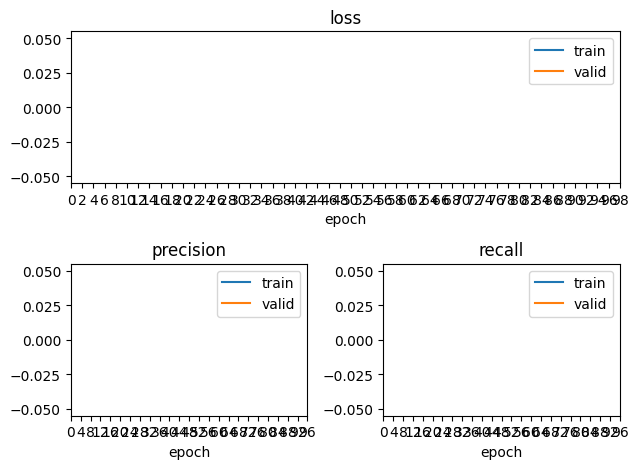

In [ ]:
trainer.plot_history('loss', plt.subplot(2, 1, 1))

trainer.plot_history('precision', plt.subplot(2, 2, 3), x_step=4)
trainer.plot_history('recall', plt.subplot(2, 2, 4), x_step=4)

plt.tight_layout()
plt.show()

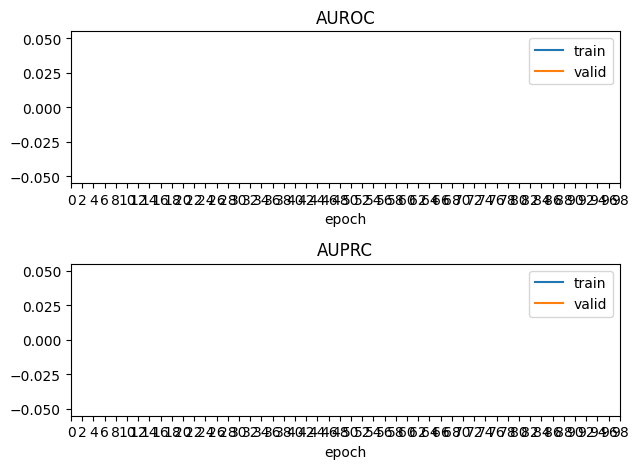

In [ ]:
trainer.plot_history('AUROC', plt.subplot(2, 1, 1))
trainer.plot_history('AUPRC', plt.subplot(2, 1, 2))

plt.tight_layout()
plt.show()

# Save results

In [ ]:
trainer.save(
    f'./scores/min{MIN_LOS_ICU:d}h/{WINDOW_LENGTH:d}h{FOLDER_SUFFIX:s}/'+
    ('scores_fl_' if USE_FL else 'scores_')+
    f'{CLIENT_COUNT:d}clients_{WINDOW_LENGTH:d}h(min{MIN_LOS_ICU:d}h).pickle'
)